# Model 1: Siamese BiLSTM Testing


In [1]:
# imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pickle
import numpy as np
import os
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [2]:
# device configuration
device = torch.device("cpu")
print(f"using device: {device}")

using device: cpu


In [3]:
# load preprocessed data
with open('preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)

test_premise_idx = data['test_premise_idx']
test_hypothesis_idx = data['test_hypothesis_idx']
test_labels = data['test_labels']

word_to_ix = data['word_to_ix']
vocab_size = data['vocab_size']
label_to_ix = data['label_to_ix']
ix_to_label = data['ix_to_label']

print(f"Test examples: {len(test_premise_idx)}")
print(f"Vocabulary size: {vocab_size}")


Test examples: 2126
Vocabulary size: 20499


In [4]:
# dataset class
class NLIDataset(Dataset):
    def __init__(self, premise_idx, hypothesis_idx, labels):
        self.premise_idx = premise_idx
        self.hypothesis_idx = hypothesis_idx
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'premise': self.premise_idx[idx],
            'hypothesis': self.hypothesis_idx[idx],
            'label': self.labels[idx]
        }


In [5]:
# collate function for padding with length limiting
MAX_SEQ_LENGTH = 200  # limit sequence length to prevent memory issues

def collate_fn(batch):
    # extract sequences and labels
    premises = [item['premise'] for item in batch]
    hypotheses = [item['hypothesis'] for item in batch]
    labels = [item['label'] for item in batch]
    
    # truncate sequences if too long
    premises = [p[:MAX_SEQ_LENGTH] for p in premises]
    hypotheses = [h[:MAX_SEQ_LENGTH] for h in hypotheses]
    
    # get max lengths in this batch
    max_premise_len = max(len(p) for p in premises)
    max_hypothesis_len = max(len(h) for h in hypotheses)
    
    # pad sequences
    padded_premises = []
    for p in premises:
        padded = p + [0] * (max_premise_len - len(p))
        padded_premises.append(padded)
    
    padded_hypotheses = []
    for h in hypotheses:
        padded = h + [0] * (max_hypothesis_len - len(h))
        padded_hypotheses.append(padded)
    
    # convert to tensors
    premises_tensor = torch.LongTensor(padded_premises)
    hypotheses_tensor = torch.LongTensor(padded_hypotheses)
    labels_tensor = torch.LongTensor(labels)
    
    return premises_tensor, hypotheses_tensor, labels_tensor


In [6]:
# create dataset
test_dataset = NLIDataset(test_premise_idx, test_hypothesis_idx, test_labels)

# hyperparameters
BATCH_SIZE = 32  # use 32 for CPU, 64 for GPU
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 2
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# create dataloader
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Number of test batches: {len(test_loader)}")


Number of test batches: 67


In [7]:
# siamese bilstm model
class SiameseBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(SiameseBiLSTM, self).__init__()
        
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # bidirectional lstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        
        # classification layers
        self.fc1 = nn.Linear(4 * hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.3)
    
    def encode(self, x):
        # embed sequence
        embeds = self.embedding(x)
        
        # pass through bilstm
        lstm_out, (h_n, c_n) = self.lstm(embeds)
        
        # concat forward and backward final hidden states
        hidden = torch.cat((h_n[0], h_n[1]), dim=1)
        return hidden
    
    def forward(self, premise, hypothesis):
        # encode both sequences with shared encoder
        premise_vec = self.encode(premise)
        hypothesis_vec = self.encode(hypothesis)
        
        # concatenate encodings
        combined = torch.cat((premise_vec, hypothesis_vec), dim=1)
        
        # classification
        out = torch.relu(self.fc1(combined))
        out = self.dropout(out)
        out = self.fc2(out)
        return out


In [8]:
# load pre-trained model
model = SiameseBiLSTM(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES)
model.load_state_dict(torch.load('best_siamese_bilstm.pth', map_location=device))
model = model.to(device)
model.eval()

criterion = nn.CrossEntropyLoss()

print(f"total parameters: {sum(p.numel() for p in model.parameters())}")


total parameters: 3677314


In [9]:
# load training results
with open('bilstm_results.pkl', 'rb') as f:
    results = pickle.load(f)

train_losses = results['train_losses']
val_losses = results['val_losses']
train_accs = results['train_accs']
val_accs = results['val_accs']
hyperparameters = results['hyperparameters']

print(f"epochs: {len(train_losses)}")
print(f"final train accuracy: {train_accs[-1]:.4f}")
print(f"final validation accuracy: {val_accs[-1]:.4f}")
print(f"best validation accuracy: {max(val_accs):.4f}")


epochs: 10
final train accuracy: 0.9926
final validation accuracy: 0.7117
best validation accuracy: 0.7347


In [10]:
# evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for premises, hypotheses, labels in dataloader:
            premises = premises.to(device)
            hypotheses = hypotheses.to(device)
            labels = labels.to(device)
            
            outputs = model(premises, hypotheses)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_preds, all_labels


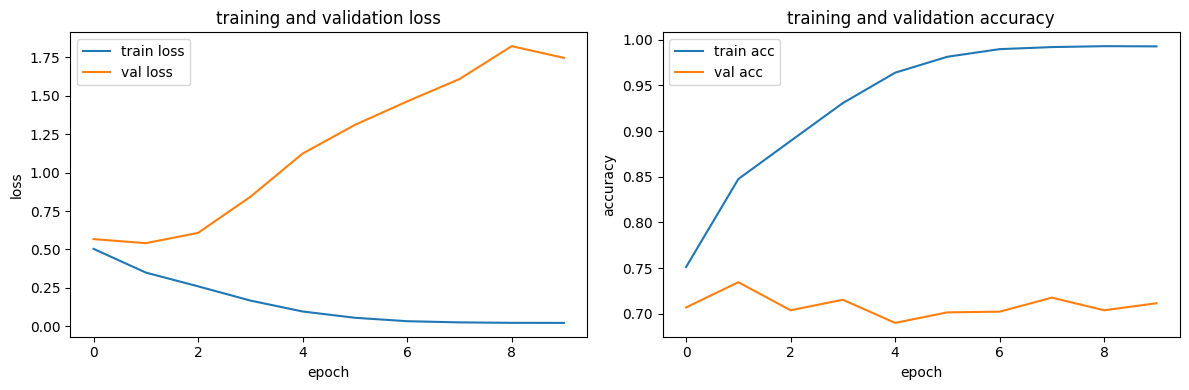

In [11]:
# plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='train loss')
ax1.plot(val_losses, label='val loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_title('training and validation loss')
ax1.legend()

ax2.plot(train_accs, label='train acc')
ax2.plot(val_accs, label='val acc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.set_title('training and validation accuracy')
ax2.legend()

plt.tight_layout()
plt.show()


In [12]:
# evaluate on test set
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

print(f"test loss: {test_loss:.4f}")
print(f"test accuracy: {test_acc:.4f}")
print(classification_report(test_labels, test_preds, target_names=['entails', 'neutral']))


test loss: 0.6090
test accuracy: 0.6952
              precision    recall  f1-score   support

     entails       0.63      0.54      0.59       842
     neutral       0.73      0.79      0.76      1284

    accuracy                           0.70      2126
   macro avg       0.68      0.67      0.67      2126
weighted avg       0.69      0.70      0.69      2126



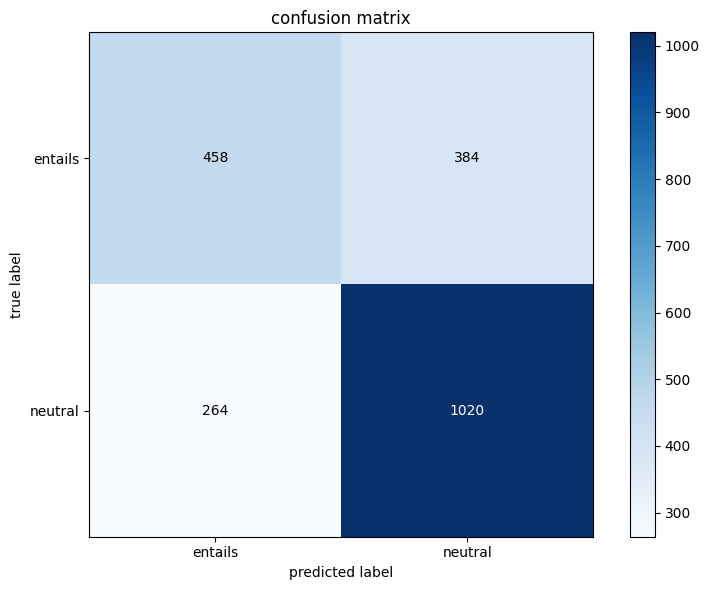

In [13]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, test_preds)
labels = ['entails', 'neutral']

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=labels, yticklabels=labels,
       ylabel='true label',
       xlabel='predicted label',
       title='confusion matrix')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [14]:
# summary
print(f"vocabulary size: {vocab_size}")
print(f"embedding dim: {EMBEDDING_DIM}")
print(f"hidden dim: {HIDDEN_DIM}")
print(f"training epochs: {len(train_losses)}")
print(f"best validation accuracy: {max(val_accs):.4f}")
print(f"test accuracy: {test_acc:.4f}")


vocabulary size: 20499
embedding dim: 128
hidden dim: 256
training epochs: 10
best validation accuracy: 0.7347
test accuracy: 0.6952
